# Spatial Interpolation of Measured Data

<img src="images/soil_sampling.png" style="width: 300px; float:right"><h>This Jupyter Notebook demonstrates how to spatially interpolate data measured at discrete locations across a catchment. For example, the soil loss rates derived from field measurements, such as those obtained using fallout radionuclide techniques or soil erodibility estimated from soil texture analysis. This process allows us to create a continuous representation of soil loss across the entire catchment, even in areas where direct measurements are not available.
    

## First we need to import the necessary libraries and iMPACT-tools    

We begin by importing the Python libraries required for data manipulation, geospatial operations, visualization, and interpolation.
    
##### Import tools

In [294]:
import os
import numpy as np  # For numerical operations and array handling
import pandas as pd  # For handling tabular data (e.g., soil loss estimates)
import rasterio  # For reading and writing raster (geospatial) data
import matplotlib.pyplot as plt  # For plotting and visualizations
from ipywidgets import interactive, Dropdown  # For creating interactive widgets
from scipy import interpolate  # For spatial interpolation methods
from scipy.spatial.distance import pdist
# Import the necessary iMPACTools (you can find these tools in the Python files stored in the */iMPACtools* folder)
os.chdir('..') # change the current working directory to the parent directory
from iMPACTools.file_IO import open_raster, save_as_raster
from iMPACTools.spatial_interpolation import idw, loocv_idw, spatial_uncertainty
from iMPACTools.spatial_interpolation import ordinary_kriging, spherical_variogram, gaussian_variogram, exponential_variogram

## Choose the case study

In [295]:
# Get list of case studies (folders in the Case_studies directory)
case_study = Dropdown(options=os.listdir('Case_studies'),description='Case Study:')
display(case_study)  

Dropdown(description='Case Study:', options=('Montefrio', 'SantaCruz'), value='Montefrio')

<img src="images/open_raster.png" style="width: 200px; float:right"><h2>Load the DEM</h2><h>
    
##### Open the file and plot the DEM

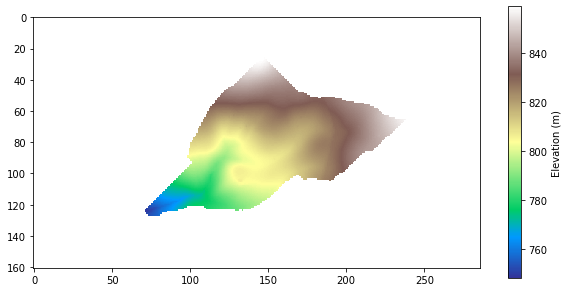

In [296]:
# Open the Digital Elevation Model (DEM) raster file
dem, metadata = open_raster(f'Case_studies/{case_study.value}/topo/','dem_catchment.tif')

# Get the number of rows and columns in the DEM
n_rows, n_cols = dem.shape
grid_x, grid_y = np.meshgrid(np.arange(0, n_rows), np.arange(0, n_cols), indexing='ij')

# Plot DEM
plt.figure(figsize=(10, 5))
plt.imshow(dem, cmap='terrain', origin='upper') # 'terrain' colormap is suitable for visualizing elevation.
plt.colorbar(label='Elevation (m)')

## Choose and load the point data

In [297]:
# Get list of data folders
data_folder = Dropdown(options=os.listdir(f'Case_studies/{case_study.value}'),description='data folder:')
display(data_folder)  

Dropdown(description='data folder:', options=('climate', 'flow', 'sampling', 'soil', 'soil_loss', 'topo'), val…

In [298]:
# Get list of data files
data_file = Dropdown(options=os.listdir(f'Case_studies/{case_study.value}/{data_folder.value}'),description='data file:')
display(data_file)  

Dropdown(description='data file:', options=('K_factor.xlsx', 'K_factor_interpolated_map(cubic).tif', 'K_factor…

Now, we load the data from an Excel file. This data should contain the location (coordinates) in the first two columns ***X*** and ***Y*** and the corresponding values for each measurement point in the third column ***Z***.

In [299]:
# Load dataset from an Excel file
data_path = f'Case_studies/{case_study.value}/{data_folder.value}/{data_file.value}'
data_df = pd.read_excel(data_path, index_col = 'ID')
data_df.head(10) # Display the first few rows

,X,Y,Z
ID,,,
M1-1,410179.49,4132795.83,0.030277
M1-2,410101.48,4132795.52,0.032112
M1-3,409982.56,4132693.42,0.031181
M1-4,410116.17,4132701.15,0.032551
M1-6,410198.43,4132695.39,0.028176
M1-7,410196.76,4132596.55,0.029003
M1-8,410146.31,4132596.40,0.030872
M1-14,409997.33,4132599.48,0.030105
M1-17,409990.46,4132497.48,0.031490


## Convert UTM coordinates to gridcell indices (row number, column number)
Convert soil loss sample locations from UTM coordinates to raster grid indices.

In [301]:
row_ids, col_ids = [], [] # Initialize the lists to store row and column indices
n_points = data_df.shape[0]  # Number of soil loss points

# Convert each coordinate to a corresponding row and column in the DEM grid
transform = metadata['transform']
for i in range(n_points):
    col = (data_df['X'].iloc[i] - transform[2]) / transform[0]
    row = (data_df['Y'].iloc[i] - transform[5]) / transform[4]
    row_ids.append(int(np.round(row))) 
    col_ids.append(int(np.round(col)))

## Plot the DEM and Sample Points
   - The DEM is displayed using a terrain colormap (`cmap='terrain'`).
   - The extracted elevation points are overlaid on the DEM using `plt.scatter()`, with colors representing their elevation values.
   - A color bar, legend, and title are added for clarity.

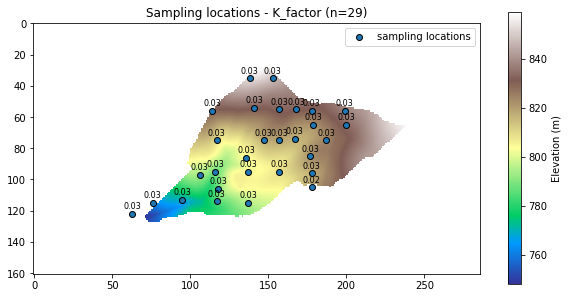

In [302]:
data_type = data_file.value.split('.')[0]
# Plot DEM with sampling points
plt.figure(figsize=(10, 5))
plt.imshow(dem, cmap='terrain', origin='upper')
plt.colorbar(label='Elevation (m)')
plt.scatter(col_ids, row_ids, edgecolor='k', cmap='coolwarm', label='sampling locations')
plt.title(f'Sampling locations - {data_type} (n={n_points})')
plt.legend()
for i, txt in enumerate(data_df['Z']):
    plt.annotate(f'{txt:.2f}', (col_ids[i], row_ids[i]), textcoords="offset points", xytext=(0,5), ha='center', fontsize=8, color='black')

## Interpolate data across the catchment
Now we perform the spatial interpolation.  We use `scipy.interpolate.griddata` to interpolate the measured values from the scattered points to a regular grid covering the entire DEM.  Several interpolation methods are available (nearest neighbor, linear, cubic).

We also use `ipywidgets` to add interactivity: a dropdown menu allows the user to select different interpolation methods and see the resulting changes in the interpolated soil loss map.

In [304]:
def interactive_spatial_interpolation(inter_method):
    
    # Perform interpolation with the selected method
    
    inter_map = interpolate.griddata(np.column_stack([row_ids, col_ids]), data_df['Z'], (grid_x, grid_y), 
                                    method=inter_method)
    inter_map[np.isnan(dem)] = np.nan
    
    # Plot interpolated soil loss map
    plt.figure(figsize=(10, 5))  # Set the figure size
    plt.imshow(inter_map, cmap = 'terrain')  # Display the interpolated map
    plt.colorbar(label=f'{data_type}') # Add a color bar indicating soil loss rates
    plt.scatter(col_ids, row_ids, edgecolor='k') # Overlay the sampling pointds
    plt.title(f'Interpolated map (method = {inter_method})')  # Add a title
    plt.show()  # Display the plot
    
    # Define the output file path
    output_path = f'Case_studies/{case_study.value}/{data_folder.value}/'
    output_file = f'{data_type}_interpolated_map({inter_method}).tif'

    save_as_raster(output_path, output_file, inter_map, metadata)
    
    print(f"Interpolated map saved to: {output_path+output_file}")

# Create an interactive widget for method selection
interactive(interactive_spatial_interpolation, inter_method = ['nearest', 'linear', 'cubic'])

interactive(children=(Dropdown(description='inter_method', options=('nearest', 'linear', 'cubic'), value='near…

### Inverse Distance Weighting
IDW is a spatial interpolation technique used to estimate unknown values at specific locations based on values from nearby known points. It assumes that **points closer to the location of interest have more influence (i.e., more weight) than those farther away**.

#### 📐 How does it work?

For any location you want to estimate, IDW computes a **weighted average** of the surrounding known values. The weights are **inversely related to distance**, typically raised to a power \( p \):

$
\hat{z}(x_0) = \frac{ \sum_{i=1}^n w_i \cdot z(x_i) }{ \sum_{i=1}^n w_i }
$

Where:

- $ \hat{z}(x_0) $: estimated value at the unknown location $ x_0 $
- $ z(x_i) $: value at the known location $ x_i $
- $ w_i = \frac{1}{d(x_i, x_0)^p} $: weight for point $ i $, based on its distance to $ x_0 $
- $ p $: power parameter (commonly $ p = 2 $)

$ p $ controls how quickly influence decreases with distance.
- **Higher \( p \)** → more influence from nearer points (more "localized").
- **Lower \( p \)** → more influence from distant points (more "global").

| \( p \) value | Effect |
|--------------|--------|
| 1            | Linear inverse |
| 2            | Squared inverse (common) |
| >2           | Strong local influence |

---
#### ✅ Advantages
- Simple and intuitive
- No need to fit a model

#### ❌ Limitations
- Does **not** consider trends or spatial structure in the data
- The optimal power parameter value needs to be estimated

#### 🧭 Use Cases
- Environmental data mapping (e.g., soil properties, rainfall)
- Real-time sensor networks

---

#### Let's define the function to compute the IDW interpolation method

In [305]:
def idw(points, values, xi, power=2):
    """
    Classic power-based Inverse Distance Weighting (IDW) interpolation over a 2D grid.

    Parameters:
        points : (n, 2) array
            Known data point coordinates.
        values : (n,) array
            Values at the data points.
        xi : tuple of 2D arrays (grid_x, grid_y)
            Coordinates where interpolation is to be computed.
        power : float
            Power parameter for inverse distance weighting (default = 2).

    Returns:
        zi : 2D array
            Interpolated grid of values.
    """
    grid_x, grid_y = xi
    xi_flat = np.column_stack((grid_x.ravel(), grid_y.ravel()))
    
    dists = np.linalg.norm(xi_flat[:, None, :] - points[None, :, :], axis=2)

    # Avoid division by zero by setting minimum distance
    dists[dists == 0] = 1e-10

    # Compute inverse distance weights
    weights = 1.0 / dists**power
    weights_sum = np.sum(weights, axis=1)

    # Compute interpolated values
    zi_flat = np.sum(weights * values, axis=1) / weights_sum
    zi = zi_flat.reshape(grid_x.shape)

    return zi

#### Now let's perform leave-one-out cross-validation (LOOCV) to estimate the error produced by different power values
For different power parameter values, **LOOCV** evaluates model performance by iteratively removing each data point, predicting its value with the rest, and calculating error metrics like:

- **RMSE** (Root Mean Square Error): emphasizes larger errors.

- **MAE** (Mean Absolute Error): gives equal weight to all errors.

This can help us choose the **optimal power parameter value** (minimum error)

In [306]:
def interactive_LOOCV(max_power):
    # List of power parameters to test for the IDW interpolation
    step = 0.5
    power_values = np.arange(0, max_power+step,step)
    results = loocv_idw(np.column_stack([row_ids, col_ids]), data_df['Z'].values, power_values)

    plt.figure(figsize=(10, 6))
    plt.plot(power_values, [results[p]['rmse'] for p in power_values], 'bo-', label='RMSE') # Plot RMSE for each power value
    plt.plot(power_values, [results[p]['mae'] for p in power_values], 'ro-', label='MAE') # Plot MAE for each power value
    plt.xlabel('Power Parameter value')
    plt.ylabel('Error Metric')
    plt.title('IDW Leave-one-out error')
    plt.legend()
    plt.grid(True)
    plt.show()
    
interactive(interactive_LOOCV, max_power=(0.5,10,0.5))

interactive(children=(FloatSlider(value=5.0, description='max_power', max=10.0, min=0.5, step=0.5), Output()),…

#### Now we define the optimal power parameter value and run the function and plot the results

In [290]:
def interactive_IDW(power_value):
    # Run the function
    inter_map_idw = idw(np.column_stack([row_ids, col_ids]), data_df['Z'].values, (grid_x, grid_y), power=power_value)
    inter_map_idw[np.isnan(dem)] = np.nan

    # Plot interpolated map
    plt.figure(figsize=(10, 5))  # Set the figure size
    plt.imshow(inter_map_idw, cmap = 'terrain')  # Display the interpolated map
    plt.colorbar(label=f'{data_type}') # Add a color bar
    plt.scatter(col_ids, row_ids, edgecolor='k') # Overlay the sampling points
    plt.title(f'Interpolated map (method: IDW)')
    plt.show()  # Display the plot 
    
    return power_value
    
interactive_idw_figure = interactive(interactive_IDW, power_value=(0,10,0.5))
display(interactive_idw_figure)

interactive(children=(FloatSlider(value=5.0, description='power_value', max=10.0, step=0.5), Output()), _dom_c…

#### Define the optimal power paramater value  and save the interpolated map as a raster file
Finally, we save the interpolated soil loss map as a GeoTIFF raster file. This allows you to use the map in other GIS software or analyses.  It's crucial to preserve the geospatial information (the transform) so the map is correctly georeferenced.

In [291]:
# Define the optimal power parameter value
power_value = interactive_idw_figure.result

# Run the function
inter_map_idw = idw(np.column_stack([row_ids, col_ids]), data_df['Z'].values, (grid_x, grid_y), power=power_value)
inter_map_idw[np.isnan(dem)] = np.nan

# Define the output file path
output_path = f'Case_studies/{case_study.value}/{data_folder.value}/'
output_file = f'{data_type}_interpolated_map(IDW).tif'

save_as_raster(output_path, output_file, inter_map_idw, metadata)

print(f"Interpolated map saved to: {output_path+output_file}")

Interpolated map saved to: ../Case_studies/Montefrio/soil/K_factor_interpolated_map(IDW).tif


### Kriging
**Kriging** is a **geostatistical interpolation** method that not only considers the distance between known and unknown points but also accounts for the **spatial autocorrelation** (i.e., how values relate to each other in space).

Named after D.G. Krige, a South African mining engineer, it's widely used in geology, soil science, environmental studies, and more.

#### 🔍 How does Kriging work?
Kriging estimates a value at an unknown location as a **weighted sum** of nearby known values, **like IDW**, but the **weights are not just based on distance**—they are based on how the variable behaves spatially.

$
\hat{z}(x_0) = \sum_{i=1}^n w_i \cdot z(x_i)
$

Where:

- $ \hat{z}(x_0) $: estimated value at unknown location
- $ z(x_i) $: known values
- $ w_i $: weights computed based on a **variogram** model

#### 🧮 Key Difference: The Variogram
Kriging requires a **variogram** to model spatial correlation. The **variogram** describes how similar points are as a function of distance:

$
\gamma(h) = \frac{1}{2} \text{Var}(z(x) - z(x + h))
$

Where:

- $ h $: distance between points
- $ \gamma(h) $: semivariance (increases with distance)

📌 The variogram helps define how the weights should be distributed based on spatial patterns, not just distance.

#### 🔧 Types of Kriging

- **Ordinary Kriging**: assumes constant but unknown mean
- **Simple Kriging**: assumes known mean
- **Universal Kriging**: accounts for trends (e.g., elevation or slope)
- **Indicator Kriging**: used for categorical data or probabilities

---

#### ✅ Advantages

- More accurate than IDW when spatial correlation is present
- Can model spatial trends and anisotropy (directional variability)

#### ❌ Disadvantages

- More complex: requires variogram fitting
- Slower than IDW
- Sensitive to the quality of the variogram

#### 🧭 When to use Kriging over IDW?

| Situation                          | Recommended Method |
|-----------------------------------|---------------------|
| You want speed and simplicity     | **IDW**             |
| You have few data points          | **IDW**             |
| You expect spatial structure      | **Kriging**         |
| You have dense, high-quality data | **Kriging**         |

---

#### Let's run the function to compute the Ordinary Kriging interpolation method and plot the results

In Ordinary Kriging, the predicted value at a point is a weighted average of the known values. The weights are calculated by solving a system based on variogram values, but only the relative differences in the variogram values matter — not the absolute scale. The sill value doesn't affect the final Kriging interpolation because Ordinary Kriging is invariant to the scale of the variogram — it's a relative method based on covariance ratios, not absolute values.

In [292]:
def interactive_ordinary_kriging(variogram, sill, range_,num_bins):
    if variogram == 'spherical':
        variogram_model = spherical_variogram
    elif variogram == 'gaussian':
        variogram_model = gaussian_variogram
    elif variogram == 'exponential':
        variogram_model = exponential_variogram
    
    # Run the function
    inter_map_kriging,sill, range_ = ordinary_kriging(np.column_stack([row_ids, col_ids]), data_df['Z'], (grid_x, grid_y), 
                                             variogram_model, sill, range_,num_bins)
    inter_map_kriging[np.isnan(dem)] = np.nan

    # Plot interpolated soil loss map
    plt.figure(figsize=(10, 5))  # Set the figure size
    plt.imshow(inter_map_kriging, cmap = 'terrain')  # Display the interpolated map
    plt.colorbar(label=f'{data_type}') # Add a color bar indicating soil loss rates
    plt.scatter(col_ids, row_ids, edgecolor='k') # Overlay the sampling points
    plt.title(f'Interpolated map (method = kriging | sill = {sill:.5f} | range = {range_:.1f})')
    plt.show()
    
    return inter_map_kriging
    
semivariance = pdist(np.asarray(data_df['Z']).reshape(-1, 1), metric='sqeuclidean') / 2
interactive_kriging_figure = interactive(interactive_ordinary_kriging, 
            variogram = ['spherical','gaussian','exponential'], 
            sill = (0,np.mean(semivariance)*2,np.mean(semivariance)/10), range_ = (1,100), num_bins = (5,40))
display(interactive_kriging_figure)

interactive(children=(Dropdown(description='variogram', options=('spherical', 'gaussian', 'exponential'), valu…

#### Save the interpolated map as a raster file

In [293]:
# Store the interpolated map as a variable
inter_map_kriging = interactive_kriging_figure.result
inter_map_kriging[np.isnan(dem)] = np.nan

# Define the output file path
output_path = f'Case_studies/{case_study.value}/{data_folder.value}/'
output_file = f'{data_type}_interpolated_map(ordinary kriging).tif'

save_as_raster(output_path, output_file, inter_map_kriging, metadata)

print(f"Interpolated map saved to: {output_path+output_file}")

Interpolated map saved to: ../Case_studies/Montefrio/soil/K_factor_interpolated_map(ordinary kriging).tif
